In [1]:
import geemap
from geemap import colormaps
from geemap import foliumap
import ee
import sys
sys.path.append('C:/Users/wb514197/Repos/GEE_Zonal/src')
from gee_tools import Catalog, ZonalStats
from gee_helpers import get_zonal_res
import pandas as pd
import os
import glob
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
from geemap.conversion import *
import geopandas as gpd

eemont not available
Google Drive tools are not available


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# ee.Authenticate()

In [4]:
ee.Initialize()

In [5]:
pac_path = r'C:\Users\wb514197\WBG\EEAPV Pacific Observatory Files - Geospatial and Big Data\Data\Admin Boundaries'
ton = gpd.read_file(os.path.join(pac_path, "TON", "ton_admbnda_adm1_2022_v2.shp"))

In [6]:
ton = ton.loc[ton.ADM1_TO!="unknown"]

In [7]:
ton.loc[ton.ADM1_TO=="Vava'u\r\nVava'u\r\nVava'u", "ADM1_TO"] = "Vava'u"

In [8]:
ton.ADM1_TO.unique()

array(['Tongatapu', "Vava'u", "Ha'apai", "'Eua", 'Niuas'], dtype=object)

In [9]:
len(ton)

5

In [10]:
ton = ton.to_crs('EPSG:4326')

In [11]:
ton = ton.to_crs("EPSG:3832")
ton.loc[:, "geometry"] = ton.buffer(100)
ton = ton.to_crs("EPSG:4326")
# ton.reset_index(inplace=True)

In [12]:
ton.geometry.is_valid

1    True
2    True
3    True
4    True
5    True
dtype: bool

In [13]:
ton_ee = geopandas_to_ee(ton)

In [14]:
aoi = ton_ee

In [19]:
coverage = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate('2019-01-01', "2022-08-31").select('cf_cvg')
def getGT0(image):
    return image.gt(0).clip(aoi).set('system:time_start', image.get('system:time_start'))
def getGTE0(image):
    return image.gte(0).clip(aoi).set('system:time_start', image.get('system:time_start'))
coverage_gt0 = coverage.map(getGT0)
coverage_gte0 = coverage.map(getGTE0)
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gt0
)
res = zs.runZonalStats()
res = res.getInfo()
df_gt0 = get_zonal_res(res)
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = coverage_gte0
)
res = zs.runZonalStats()
res = res.getInfo()
df_gte0 = get_zonal_res(res)
cols_cf = ['cf' in col for col in df_gt0.columns]
cols = list(~pd.Series(cols_cf))
df_pct = df_gt0.iloc[:, cols].join(df_gt0.loc[:, cols_cf].divide(df_gte0.loc[:, cols_cf]))
def rename_func(col):
    if "cf_cvg" in col:
        p = col.split("_")
        new_name = "pct"+"__"+p[0]
        return(new_name)
    else:
        return col
df_pct.rename(rename_func, axis=1, inplace=True)
df_pct.reset_index(inplace=True)
df_pct_re = pd.wide_to_long(
    df_pct,
    stubnames = ['pct'],
    i = 'index',
    j = 'date',
    sep = "__"
)
df_pct_re.reset_index(inplace=True)
df_pct_re.loc[:,"date"] = pd.to_datetime(df_pct_re.date, format="%Y%m%d")

<AxesSubplot:xlabel='date', ylabel='pct'>

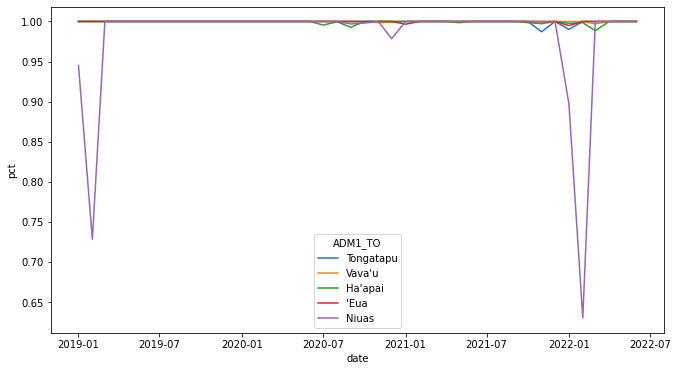

In [20]:
fig, ax = plt.subplots(figsize=(11, 6))
sns.lineplot(data=df_pct_re, x="date", y="pct", hue="ADM1_TO")

In [21]:
def smoothenViirs(collection, window_size):

    def prepareImage(img):
        rad = img.select('avg_rad')
        cf_cvg = img.select('cf_cvg') #.rename('avg_rad')
        cf_eq0 = cf_cvg.gt(0)
        img_masked = rad.mask(cf_eq0)

        date = img.date()
        # add a time variable
        months = date.difference(ee.Date('1970-01-01'), 'month')
        return img_masked.addBands(ee.Image(months).rename('time')).float()

    def smoother(t):
        # helper function to apply linear regression equation
        def applyFit(img):
            return img.select('time').multiply(fit.select('scale')) \
                    .add(fit.select('offset')) \
                    .set('system:time_start',img.get('system:time_start')) \
                    .rename('avg_rad')
        
        t = ee.Date(t)
        
        window = data.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month'))
        
        fit = window.select(['time','avg_rad']) \
            .reduce(ee.Reducer.linearFit())
        
        return window.map(applyFit).toList(10)
    
    # function to reduce time stacked linear regression results
    # requires that a variable 'fitIC' exists from the smooter function
    def reduceFits(t):
        t = ee.Date(t)
        return fitIC.filterDate(t.advance(-window_size,'month'),t.advance(window_size,'month')) \
                  .mean().set('system:time_start',t.millis()).rename('avg_rad')
    
    def replace(original):
        date = original.date()
        smoothed_sel = smoothed.filterDate(date, date.advance(1, 'day'))
        smooth = smoothed_sel.first()
        return smooth.where(original, original)
    
    data = collection \
        .map(prepareImage)
    
    # get unique dates
    dates = ee.List(data.aggregate_array('system:time_start'))
    
    fitIC = ee.ImageCollection(dates.map(smoother).flatten())
    
    smoothed = ee.ImageCollection(dates.map(reduceFits))
    
    collection_fill = data.select('avg_rad').map(replace)
    return collection_fill

In [15]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG") \
    .select('avg_rad')
#     .filterDate('2016-01-01', "2022-08-31")

In [23]:
viirs_interpolated = smoothenViirs(viirs, 3)

In [32]:
def getBool(img):
    rad = img.select('avg_rad')
    img_bool = rad.gt(1)
    return img_bool.set('system:time_start', img.get('system:time_start'))

In [33]:
viirs_bool = viirs.map(getBool)

In [34]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG',
    target_features = aoi,
    statistic_type = 'sum',
    scale = 500,
    frequency = 'original',
    ee_dataset = viirs_bool
)
res = zs.runZonalStats()
res = res.getInfo()
df_bool = get_zonal_res(res)

In [24]:
zs = ZonalStats(
    collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
    target_features = aoi,
    statistic_type= 'sum',
    output_name = '',
    scale = 500,
#     start_year = 2019,
#     end_year = 2022,
    frequency = 'original',
    temporal_stat = 'mean',
    output_dir = '',
    ee_dataset = viirs
)
res = zs.runZonalStats()
res = res.getInfo()

In [27]:
df_ntl = get_zonal_res(res)

In [28]:
# zs = ZonalStats(
#     collection_id = 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
#     target_features = aoi,
#     statistic_type= 'sum',
#     output_name = '',
#     scale = 500,
# #     start_year = 2019,
# #     end_year = 2022,
#     frequency = 'original',
#     temporal_stat = 'mean',
#     output_dir = '',
#     ee_dataset = viirs_interpolated
# )
# res = zs.runZonalStats()
# res = res.getInfo()

In [29]:
# df_ntl_int = get_zonal_res(res)

In [35]:
df_ntl = df_bool.copy()

In [36]:
def rename_func(col):
    if "avg_rad" in col:
        p = col.split("_")
        new_name = "rad"+"__"+p[0]
        return(new_name)
    else:
        return col
df_ntl.rename(rename_func, axis=1, inplace=True)
df_ntl.reset_index(inplace=True)

In [37]:
df_ntl.head(2)

,index,rad__20140101,rad__20140201,rad__20140301,rad__20140401,rad__20140501,rad__20140601,rad__20140701,rad__20140801,rad__20140901,...,rad__20220201,rad__20220301,rad__20220401,rad__20220501,rad__20220601,ADM0_EN,ADM0_PCODE,ADM0_TO,ADM1_PCODE,ADM1_TO
0,0,132.886275,167.513725,109.203922,120.560784,116.478431,81.337255,84.858824,128.262745,122.592157,...,281.101961,277.956863,285.713725,264.239216,304.592157,Kingdom of Tonga,TO,Puleʻanga Fakatuʻi ʻo Tonga,TO1,Tongatapu
1,1,16.349020,28.658824,10.556863,7.956863,7.972549,9.541176,14.270588,18.964706,15.223529,...,34.141176,40.494118,33.137255,39.360784,43.537255,Kingdom of Tonga,TO,Puleʻanga Fakatuʻi ʻo Tonga,TO2,Vava'u


In [38]:
df_ntl_re = pd.wide_to_long(
    df_ntl,
    stubnames = ['rad'],
    i = 'index',
    j = 'date',
    sep = "__"
)
df_ntl_re.reset_index(inplace=True)
df_ntl_re.loc[:,"date"] = pd.to_datetime(df_ntl_re.date, format="%Y%m%d")

In [39]:
df_ntl_re.head()

,index,date,ADM0_PCODE,ADM0_TO,ADM0_EN,ADM1_PCODE,ADM1_TO,rad
0,0,2014-01-01,TO,Puleʻanga Fakatuʻi ʻo Tonga,Kingdom of Tonga,TO1,Tongatapu,132.886275
1,1,2014-01-01,TO,Puleʻanga Fakatuʻi ʻo Tonga,Kingdom of Tonga,TO2,Vava'u,16.349020
2,2,2014-01-01,TO,Puleʻanga Fakatuʻi ʻo Tonga,Kingdom of Tonga,TO3,Ha'apai,12.000000
3,3,2014-01-01,TO,Puleʻanga Fakatuʻi ʻo Tonga,Kingdom of Tonga,TO4,'Eua,4.168627
4,4,2014-01-01,TO,Puleʻanga Fakatuʻi ʻo Tonga,Kingdom of Tonga,TO5,Niuas,0.000000


In [40]:
one = df_ntl_re.loc[df_ntl_re.ADM1_TO=="Tongatapu"].copy()

In [41]:
df_sel = df_ntl_re.loc[df_ntl_re.date>='2020-01-01'].copy()
df_sel = df_sel.loc[df_sel.ADM1_TO!="Ha'apai"].copy()

In [42]:
sns.set()

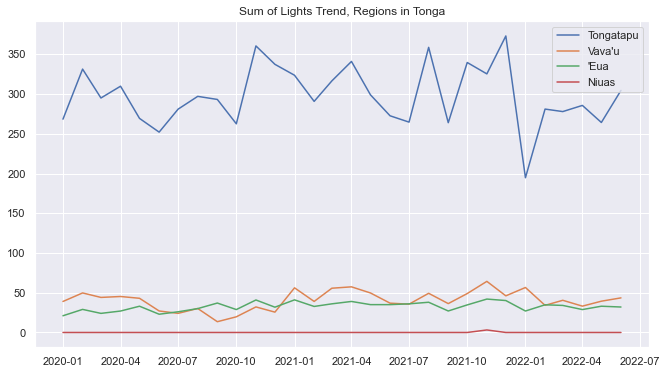

In [43]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df_sel, x="date", y="rad",
                  hue="ADM1_TO")
ax.set(xlabel="", ylabel="", title="Sum of Lights Trend, Regions in Tonga")
plt.legend(title='', loc='upper right')
# plt.savefig("../docs/images/Tonga_NTL_Chart.png", facecolor='white', dpi=300)

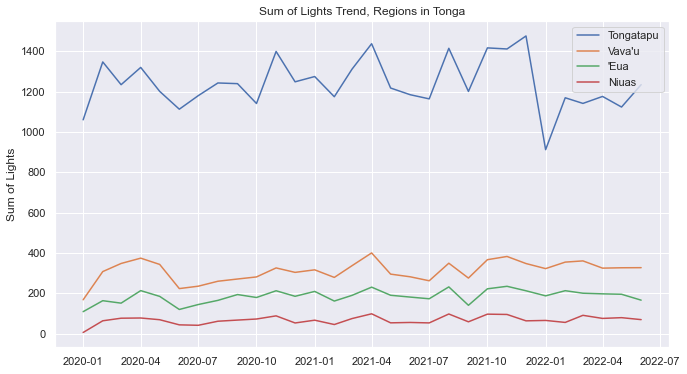

In [58]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df_sel, x="date", y="rad",
                  hue="ADM1_TO")
ax.set(xlabel="", ylabel="Sum of Lights", title="Sum of Lights Trend, Regions in Tonga")
plt.legend(title='', loc='upper right')
plt.savefig("../docs/images/Tonga_NTL_Chart.png", facecolor='white', dpi=300)

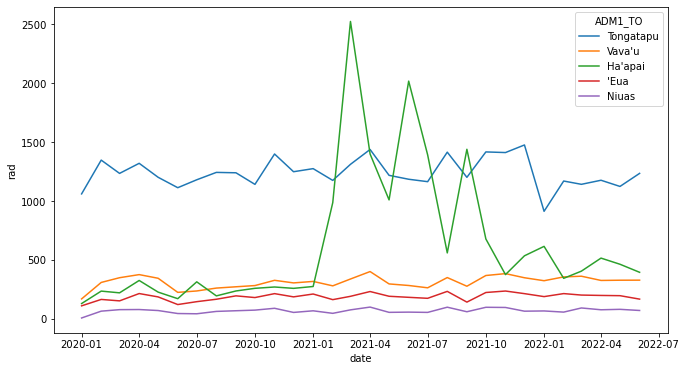

In [48]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df_ntl_re.loc[df_ntl_re.date>='2020-01-01'], x="date", y="rad", 
                  hue="ADM1_TO") #style="index", style_order=['interpolated', 'raw'] dashes=[(3, 3)])
# ax.set(xlabel="", ylabel="Sum of Lights", title="Sum of Lights Trend - Lae, Papua New Guinea")
# ax.lines[0].set_linestyle("dotted")
# plt.legend(title='', loc='upper right', labels=['Raw Data', 'Interpolated'])
# plt.savefig("../docs/images/LAE.png", facecolor='white', dpi=300)

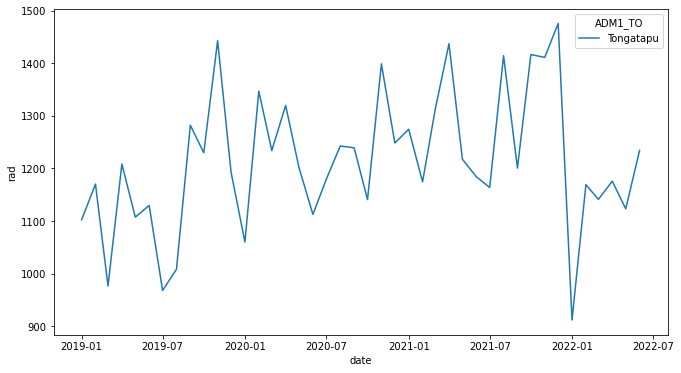

In [37]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=one.loc[one.date>='2019-01-01'], x="date", y="rad", 
                  hue="ADM1_TO") #style="index", style_order=['interpolated', 'raw'] dashes=[(3, 3)])
# ax.set(xlabel="", ylabel="Sum of Lights", title="Sum of Lights Trend - Lae, Papua New Guinea")
# ax.lines[0].set_linestyle("dotted")
# plt.legend(title='', loc='upper right', labels=['Raw Data', 'Interpolated'])
# plt.savefig("../docs/images/LAE.png", facecolor='white', dpi=300)

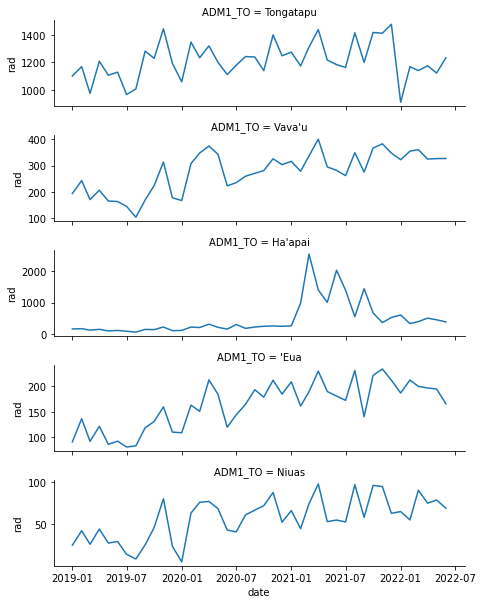

In [47]:
# fig, ax = plt.subplots(figsize=(11, 6))
g = sns.FacetGrid(df_ntl_re.loc[df_ntl_re.date>='2019-01-01'],  row="ADM1_TO", sharey=False,
                  height=1.7, aspect=4)
g.map(sns.lineplot, "date", "rad")

In [132]:
df_ntl.index = ['raw']
df_ntl_int.index = ['interpolated']

In [133]:
df_ntl = pd.concat([df_ntl, df_ntl_int])

In [134]:
def rename_func(col):
    if "avg_rad" in col:
        p = col.split("_")
        new_name = "rad"+"__"+p[0]
        return(new_name)
    else:
        return col
df_ntl.rename(rename_func, axis=1, inplace=True)
df_ntl.reset_index(inplace=True)

C:\Users\wb514197\AppData\Local\Temp\ipykernel_3988\1464334999.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_ntl.reset_index(inplace=True)


In [135]:
df_ntl_re = pd.wide_to_long(
    df_ntl,
    stubnames = ['rad'],
    i = 'index',
    j = 'date',
    sep = "__"
)
df_ntl_re.reset_index(inplace=True)
df_ntl_re.loc[:,"date"] = pd.to_datetime(df_ntl_re.date, format="%Y%m%d")

In [65]:
sns.set()

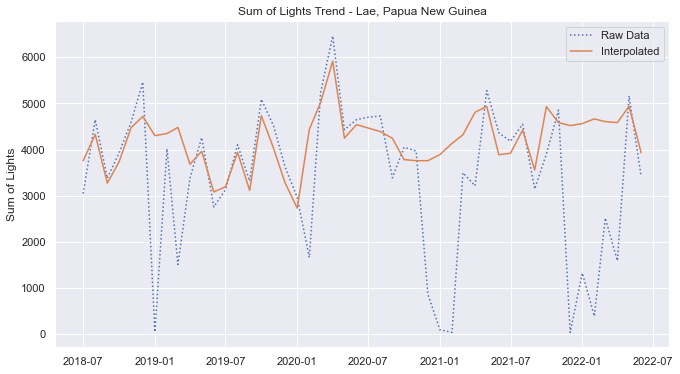

In [136]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df_ntl_re.loc[df_ntl_re.date>='2018-07-01'], x="date", y="rad", 
                  hue="index") #style="index", style_order=['interpolated', 'raw'] dashes=[(3, 3)])
ax.set(xlabel="", ylabel="Sum of Lights", title="Sum of Lights Trend - Lae, Papua New Guinea")
ax.lines[0].set_linestyle("dotted")
plt.legend(title='', loc='upper right', labels=['Raw Data', 'Interpolated'])
plt.savefig("../docs/images/LAE.png", facecolor='white', dpi=300)

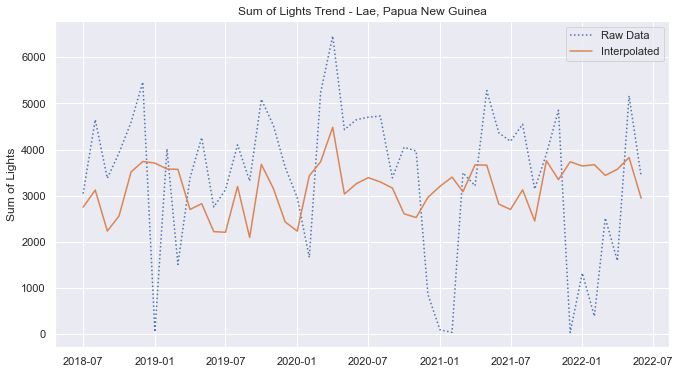

In [124]:
fig, ax = plt.subplots(figsize=(11, 6))
ax = sns.lineplot(data=df_ntl_re.loc[df_ntl_re.date>='2018-07-01'], x="date", y="rad", 
                  hue="index") #style="index", style_order=['interpolated', 'raw'] dashes=[(3, 3)])
ax.set(xlabel="", ylabel="Sum of Lights", title="Sum of Lights Trend - Lae, Papua New Guinea")
ax.lines[0].set_linestyle("dotted")
plt.legend(title='', loc='upper right', labels=['Raw Data', 'Interpolated'])
plt.savefig("../docs/images/LAE.png", facecolor='white', dpi=300)

<AxesSubplot:ylabel='Sum of Lights'>